In [1]:
try:
    from fastlane_bot.tools.cpc import ConstantProductCurve as CPC, CPCContainer, T, CPCInverter, Pair
    from fastlane_bot.tools.optimizer import F, MargPOptimizer
    import fastlane_bot.tools.invariants.functions as f
    from fastlane_bot.testing import *

except:
    from tools.cpc import ConstantProductCurve as CPC, CPCContainer, T, CPCInverter, Pair
    from tools.optimizer import MargPOptimizer
    import tools.invariants.functions as f
    from tools.testing import *

print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CPC))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(MargPOptimizer))

#plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = [12,6]
# from fastlane_bot import __VERSION__
# require("3.0", __VERSION__)

imported m, np, pd, plt, os, sys, decimal; defined iseq, raises, require, Timer
ConstantProductCurve v3.5 (22/Apr/2023)
MargPOptimizer v5.3-b3 (30/Apr/2024)


# CPC-Only incl new curves [NBTest069]

Note: the core CPC tests are in NBTest 002

In [2]:
CURVES = {
    "s1": CPC.from_solidly(x=10, y=10),
    "s2": CPC.from_solidly(x=10, y=10, price_spread=1e-6),
    "s1a": CPC.from_solidly(x=100, y=100),
    "s2a": CPC.from_solidly(x=100, y=100, price_spread=1e-6),
    "s3": CPC.from_solidly(x=1000, y=2000),   
    "s4": CPC.from_solidly(x=1, y=2000), 
}

## Solidly tests

In [3]:
help(CPC.from_solidly)

Help on method from_solidly in module tools.cpc:

from_solidly(*, k=None, x=None, y=None, price_spread=None, pair=None, fee=None, cid=None, descr=None, params=None, as_list=True) method of abc.ABCMeta instance
    constructor: from a Solidly curve (see class docstring for other parameters)*
    
    :k:             Solidly pool constant, x^3 y + x y^3 = k*
    :x:             current pool liquidity in token x*
    :y:             current pool liquidity in token y*
    :price_spread:  price spread to use for converting constant price -> constant product
    :as_list:       if True (default) returns a list of curves, otherwise a single curve
                    (see note below and note that as_list=False is deprecated)
    
    exactly 2 out of those three must be given; the third one is calculated
    
    The Solidly curve is NOT a constant product curve, as it follows the equation
    
        x^3 y + x y^3 = k
        
    where k is the pool invariant. This curve is a stable swap cu

In [4]:
#CPC.from_solidly(k=1, x=1)

In [5]:
#CPC.from_solidly(k=1, x=1, y=1)
assert raises(CPC.from_solidly, k=1, x=1, y=1).startswith("exactly 2 out of k,x,y")
assert raises(CPC.from_solidly, k=1).startswith("exactly 2 out of k,x,y")
assert raises(CPC.from_solidly, x=1).startswith("exactly 2 out of k,x,y")
assert raises(CPC.from_solidly, y=1).startswith("exactly 2 out of k,x,y")
assert raises(CPC.from_solidly).startswith("exactly 2 out of k,x,y")

assert raises(CPC.from_solidly, k=1, x=1) == 'providing k, x not implemented yet'
assert raises(CPC.from_solidly, k=1, y=1) == 'providing k, y not implemented yet'

In [6]:
assert len(CPC.from_solidly(x=1, y=2000)) == 0
assert raises(CPC.from_solidly,x=1, y=2000, as_list=False).startswith('x=1 is outside the range')

### Curve s1 (x=10, y=10) and s2 (ditto, but spread = 1e-6)

In [7]:
crv_l = CURVES["s1"] # CPC.from_solidly(x=10, y=10)
crv = crv_l[0]
cp = crv.params
fn = f.Solidly(k=cp.s_k)
assert crv.constr == "solidly"
assert cp.s_x == 10
assert cp.s_y == 10
assert cp.s_k == 20000
assert cp.s_k == cp.s_x**3 * cp.s_y + cp.s_y**3 * cp.s_x
assert cp.s_kbar == 10
assert iseq(cp.s_kbar, (cp.s_k/2)**0.25)
assert iseq(cp.s_kbar, 10)
assert iseq(cp.s_xmin, 50/9)
assert iseq(cp.s_xmax, 130/9)
assert cp.s_price_spread == CPC.SOLIDLY_PRICE_SPREAD
assert cp.s_price_spread == 0.06
assert iseq(cp.s_cpck/((cp.s_cpcx0)**2)-1, cp.s_price_spread)  # cpck / cpcx^2 = p; p0 = 1
assert iseq(1-cp.s_cpck/((cp.s_cpcx0+cp.s_xmax-cp.s_xmin)**2), 1-1/(1+cp.s_price_spread))
assert iseq(crv.x_act, 40/9)
assert iseq(crv.y_act, 40/9)
assert iseq(crv.y_act, crv.x_act)

In [8]:
crv_l = CURVES["s2"] # CPC.from_solidly(x=10, y=10)
crv = crv_l[0]
cp = crv.params
fn = f.Solidly(k=cp.s_k)
assert crv.constr == "solidly"
assert cp.s_x == 10
assert cp.s_y == 10
assert cp.s_k == 20000
assert cp.s_k == cp.s_x**3 * cp.s_y + cp.s_y**3 * cp.s_x
assert cp.s_kbar == 10
assert iseq(cp.s_kbar, (cp.s_k/2)**0.25)
assert iseq(cp.s_kbar, 10)
assert iseq(cp.s_xmin, 50/9)
assert iseq(cp.s_xmax, 130/9)
#assert cp.s_price_spread == CPC.SOLIDLY_PRICE_SPREAD
assert cp.s_price_spread == 1e-6
assert iseq(cp.s_cpck/((cp.s_cpcx0)**2)-1, cp.s_price_spread)  # cpck / cpcx^2 = p; p0 = 1
assert iseq(1-cp.s_cpck/((cp.s_cpcx0+cp.s_xmax-cp.s_xmin)**2), 1-1/(1+cp.s_price_spread))
assert iseq(crv.x_act, 40/9)
assert iseq(crv.y_act, 40/9)
assert iseq(crv.y_act, crv.x_act)

### Curve s1a (x=100, y=100) and s2a (ditto, but spread = 1e-6)

In [9]:
crv_l = CURVES["s1a"] # CPC.from_solidly(x=100, y=100)
crv = crv_l[0]
cp = crv.params
fn = f.Solidly(k=cp.s_k)
assert crv.constr == "solidly"
assert cp.s_x == 100
assert cp.s_y == 100
assert cp.s_k == 200000000
assert cp.s_k == cp.s_x**3 * cp.s_y + cp.s_y**3 * cp.s_x
assert cp.s_kbar == 100
assert iseq(cp.s_kbar, (cp.s_k/2)**0.25)
assert iseq(cp.s_kbar, 100)
assert iseq(cp.s_xmin, 500/9)
assert iseq(cp.s_xmax, 1300/9)
assert cp.s_price_spread == CPC.SOLIDLY_PRICE_SPREAD
assert cp.s_price_spread == 0.06
assert iseq(cp.s_cpck/((cp.s_cpcx0)**2)-1, cp.s_price_spread)  # cpck / cpcx^2 = p; p0 = 1
assert iseq(1-cp.s_cpck/((cp.s_cpcx0+cp.s_xmax-cp.s_xmin)**2), 1-1/(1+cp.s_price_spread))
assert iseq(crv.x_act, 400/9)
assert iseq(crv.y_act, 400/9)
assert iseq(crv.y_act, crv.x_act)

In [10]:
crv_l = CURVES["s2a"] # CPC.from_solidly(x=100, y=100, price_spread=1e-6)
crv = crv_l[0]
cp = crv.params
fn = f.Solidly(k=cp.s_k)
assert crv.constr == "solidly"
assert cp.s_x == 100
assert cp.s_y == 100
assert cp.s_k == 200000000
assert cp.s_k == cp.s_x**3 * cp.s_y + cp.s_y**3 * cp.s_x
assert cp.s_kbar == 100
assert iseq(cp.s_kbar, (cp.s_k/2)**0.25)
assert iseq(cp.s_kbar, 100)
assert iseq(cp.s_xmin, 500/9)
assert iseq(cp.s_xmax, 1300/9)
#assert cp.s_price_spread == CPC.SOLIDLY_PRICE_SPREAD
assert cp.s_price_spread == 1e-6
assert iseq(cp.s_cpck/((cp.s_cpcx0)**2)-1, cp.s_price_spread)  # cpck / cpcx^2 = p; p0 = 1
assert iseq(1-cp.s_cpck/((cp.s_cpcx0+cp.s_xmax-cp.s_xmin)**2), 1-1/(1+cp.s_price_spread))
assert iseq(crv.x_act, 400/9)
assert iseq(crv.y_act, 400/9)
assert iseq(crv.y_act, crv.x_act)

### Curve s3 (off centre)

In [11]:
crv

ConstantProductCurve(k=7901242469135804.0, x=88888933.33333336, x_act=44.44444444444444, y_act=44.44444444444446, alpha=0.5, pair='TKNB/TKNQ', cid='None', fee=None, descr=None, constr='solidly', params={'s_x': 100, 's_y': 100, 's_k': 200000000, 's_kbar': 100.0, 's_cpck': 7901242469135804.0, 's_cpcx0': 88888888.88888891, 's_xmin': 55.55555555555556, 's_xmax': 144.44444444444446, 's_price_spread': 1e-06})

In [12]:
crv_l = CURVES["s3"] # CPC.from_solidly(x=100, y=100)
crv = crv_l[0]
cp = crv.params
fn = f.Solidly(k=cp.s_k)
assert crv.constr == "solidly"
assert cp.s_x == 1000
assert cp.s_y == 2000
assert cp.s_k == 10000000000000
assert cp.s_k == cp.s_x**3 * cp.s_y + cp.s_y**3 * cp.s_x
#assert cp.s_kbar == 100
assert iseq(cp.s_kbar, (cp.s_k/2)**0.25)
assert iseq(cp.s_kbar, 1495.3487812212206)
assert iseq(cp.s_xmin, 830.7493229006781)
assert iseq(cp.s_xmax, 2159.948239541763)
assert cp.s_price_spread == CPC.SOLIDLY_PRICE_SPREAD
assert cp.s_price_spread == 0.06
assert iseq(cp.s_cpck/((cp.s_cpcx0)**2)-1, cp.s_price_spread)  # cpck / cpcx^2 = p; p0 = 1
assert iseq(1-cp.s_cpck/((cp.s_cpcx0+cp.s_xmax-cp.s_xmin)**2), 1-1/(1+cp.s_price_spread))
assert iseq(crv.x_act, 169.25067709932193)
assert iseq(crv.y_act, 1159.948239541763)

### Curve 4 (out of range)

In [13]:
crv_l = CURVES["s4"] # CPC.from_solidly(x=100, y=100)
assert len(crv_l) == 0

## Solidly plots [NOTEST]

### Curves 1 and 2

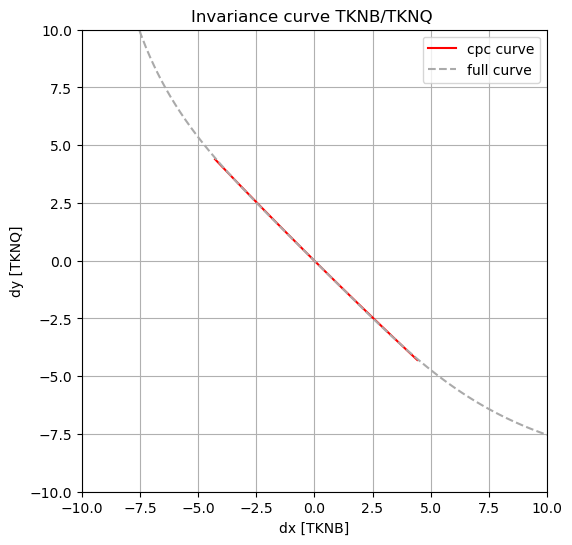

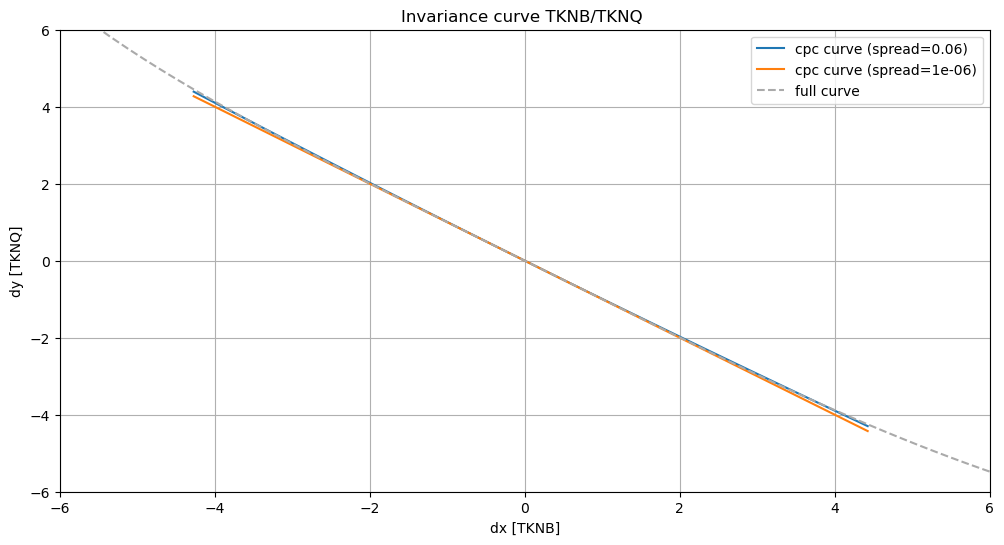

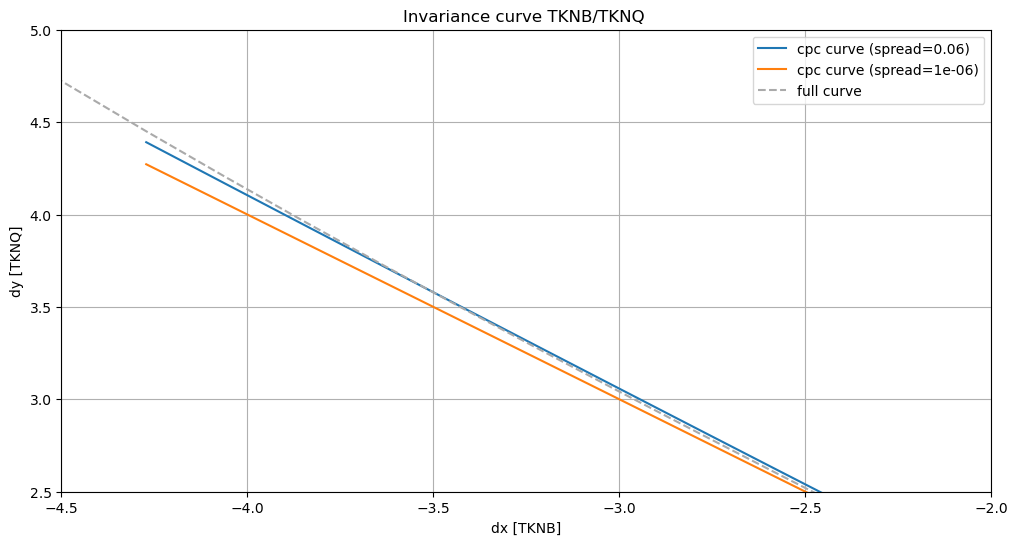

In [14]:
crv  = CURVES["s1"][0] # CPC.from_solidly(x=10, y=10)
cp   = crv.params
crv2 = CURVES["s2"][0] # CPC.from_solidly(x=10, y=10, price_spread=XXX)
fn = f.Solidly(k=cp.s_k)
x0 = cp.s_x
LIM = cp.s_kbar

xv = np.linspace(-LIM+0.001, 1.1*LIM, 100)
plt.figure(figsize=(6,6))
crv.plot(xvals=xv, color="red", label="cpc curve")
yv = [fn(xx+x0) - fn(x0) for xx in xv]
plt.plot(xv, yv, color="#aaa", linestyle="--", label="full curve")
plt.legend()
plt.xlim(-LIM, LIM)
plt.ylim(-LIM, LIM)
plt.savefig("/Users/skl/Desktop/img1.jpg")
plt.show()

for crv_ in [crv, crv2]:
    crv_.plot(xvals=xv, label=f"cpc curve (spread={crv_.params.s_price_spread})")
yv = [fn(xx+x0) - fn(x0) for xx in xv]
plt.plot(xv, yv, color="#aaa", linestyle="--", label="full curve")
plt.legend()
plt.xlim(-.6*LIM, .6*LIM)
plt.ylim(-.6*LIM, .6*LIM)
plt.savefig("/Users/skl/Desktop/img2.jpg")
plt.show()

for crv_ in [crv, crv2]:
    crv_.plot(xvals=xv, label=f"cpc curve (spread={crv_.params.s_price_spread})")
yv = [fn(xx+x0) - fn(x0) for xx in xv]
plt.plot(xv, yv, color="#aaa", linestyle="--", label="full curve")
plt.legend()
plt.xlim(-.45*LIM, -.2*LIM)
plt.ylim(.25*LIM, .5*LIM)
plt.savefig("/Users/skl/Desktop/img3.jpg")
plt.show()

### Curves 1a and 2a

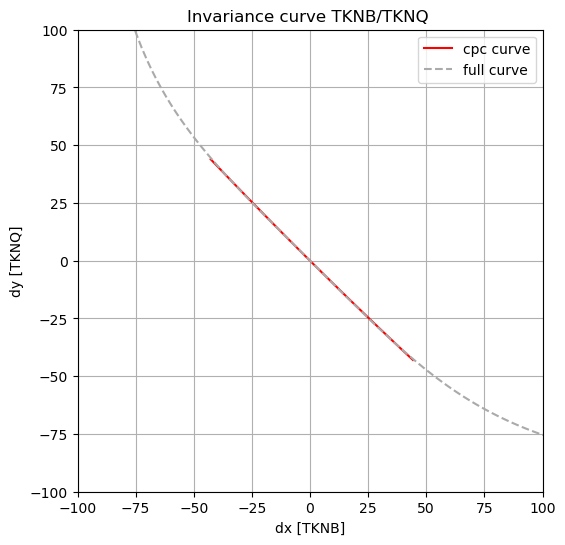

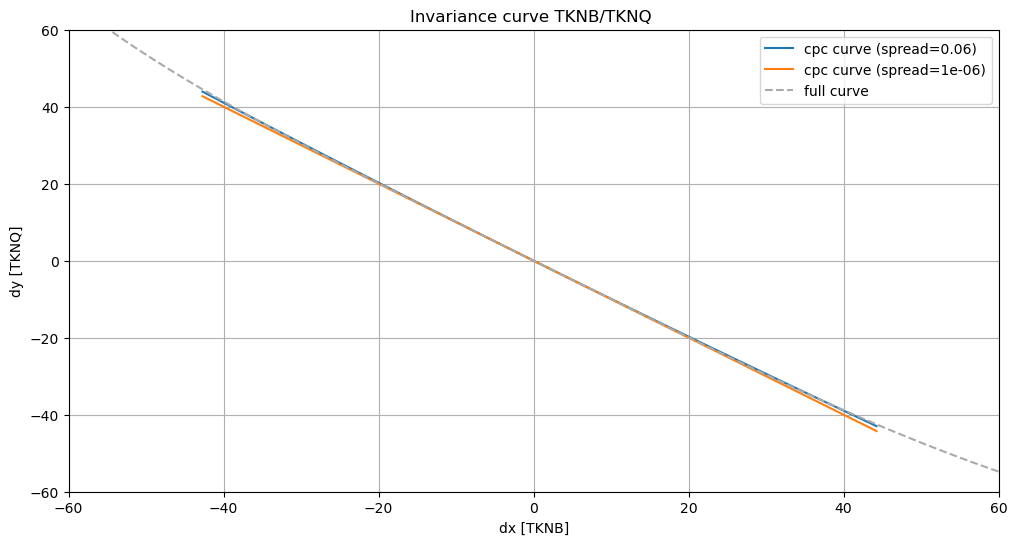

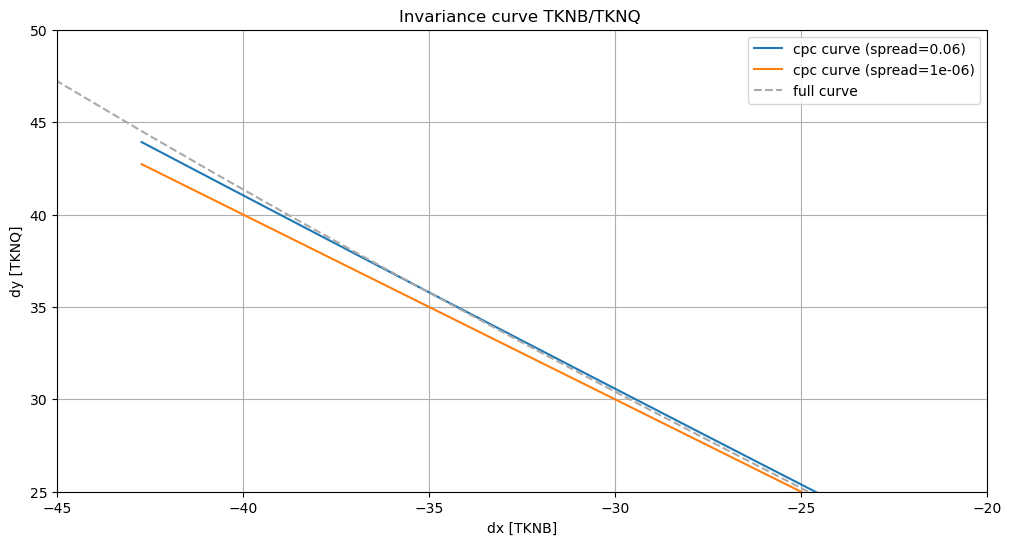

In [15]:
crv  = CURVES["s1a"][0] # CPC.from_solidly(x=10, y=10)
cp   = crv.params
crv2 = CURVES["s2a"][0] # CPC.from_solidly(x=10, y=10, price_spread=XXX)
fn = f.Solidly(k=cp.s_k)
x0 = cp.s_x
LIM = cp.s_kbar

xv = np.linspace(-LIM+0.001, 1.1*LIM, 100)
plt.figure(figsize=(6,6))
crv.plot(xvals=xv, color="red", label="cpc curve")
yv = [fn(xx+x0) - fn(x0) for xx in xv]
plt.plot(xv, yv, color="#aaa", linestyle="--", label="full curve")
plt.legend()
plt.xlim(-LIM, LIM)
plt.ylim(-LIM, LIM)
plt.savefig("/Users/skl/Desktop/img1.jpg")
plt.show()

for crv_ in [crv, crv2]:
    crv_.plot(xvals=xv, label=f"cpc curve (spread={crv_.params.s_price_spread})")
yv = [fn(xx+x0) - fn(x0) for xx in xv]
plt.plot(xv, yv, color="#aaa", linestyle="--", label="full curve")
plt.legend()
plt.xlim(-.6*LIM, .6*LIM)
plt.ylim(-.6*LIM, .6*LIM)
plt.savefig("/Users/skl/Desktop/img2.jpg")
plt.show()

for crv_ in [crv, crv2]:
    crv_.plot(xvals=xv, label=f"cpc curve (spread={crv_.params.s_price_spread})")
yv = [fn(xx+x0) - fn(x0) for xx in xv]
plt.plot(xv, yv, color="#aaa", linestyle="--", label="full curve")
plt.legend()
plt.xlim(-.45*LIM, -.2*LIM)
plt.ylim(.25*LIM, .5*LIM)
plt.savefig("/Users/skl/Desktop/img3.jpg")
plt.show()


### Curve 3

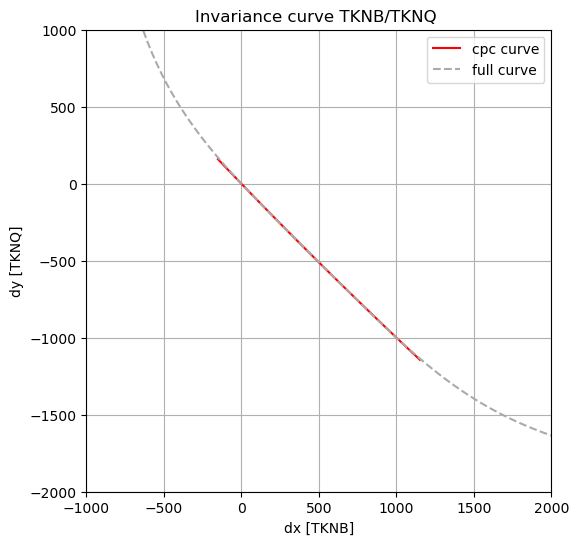

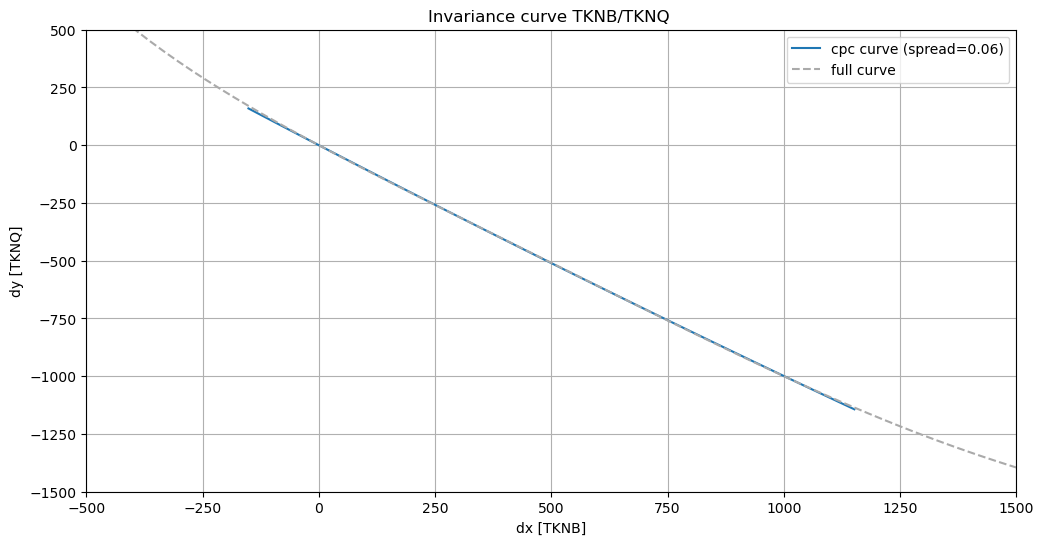

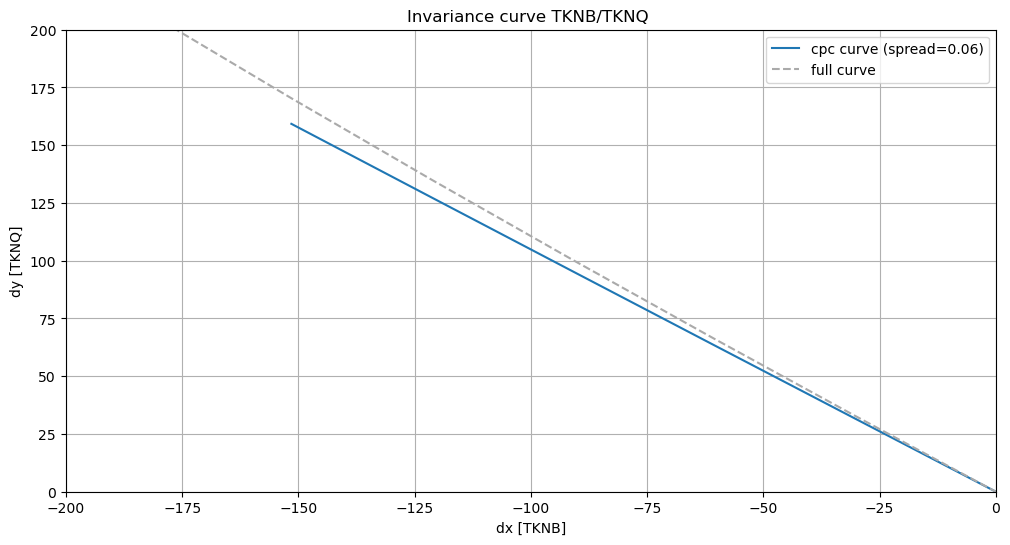

In [16]:
crv  = CURVES["s3"][0] # CPC.from_solidly(x=1000, y=2000)
cp   = crv.params
# crv2 = CURVES["s2a"][0] # CPC.from_solidly(x=10, y=10, price_spread=XXX)
fn = f.Solidly(k=cp.s_k)
x0 = cp.s_x

xv = np.linspace(-1000+0.001, 2000, 100)
plt.figure(figsize=(6,6))
crv.plot(xvals=xv, color="red", label="cpc curve")
yv = [fn(xx+x0) - fn(x0) for xx in xv]
plt.plot(xv, yv, color="#aaa", linestyle="--", label="full curve")
plt.legend()
plt.xlim(-1000, 2000)
plt.ylim(-2000, 1000)
plt.savefig("/Users/skl/Desktop/img1.jpg")
plt.show()

for crv_ in [crv]:
    crv_.plot(xvals=xv, label=f"cpc curve (spread={crv_.params.s_price_spread})")
yv = [fn(xx+x0) - fn(x0) for xx in xv]
plt.plot(xv, yv, color="#aaa", linestyle="--", label="full curve")
plt.legend()
plt.xlim(-500, 1500)
plt.ylim(-1500,500)
plt.savefig("/Users/skl/Desktop/img2.jpg")
plt.show()

for crv_ in [crv]:
    crv_.plot(xvals=xv, label=f"cpc curve (spread={crv_.params.s_price_spread})")
yv = [fn(xx+x0) - fn(x0) for xx in xv]
plt.plot(xv, yv, color="#aaa", linestyle="--", label="full curve")
plt.legend()
plt.xlim(-200, 0)
plt.ylim(0,200)
plt.savefig("/Users/skl/Desktop/img3.jpg")
plt.show()


## Optimizer [NOTEST]

We start with three curves: two "USD/ETH" at 2000 and 2100 respectively but that unfortunately use different USD references (USDC and USDT) and one Solidly stable swap with USDC/USDT

pair = USDC/USDT


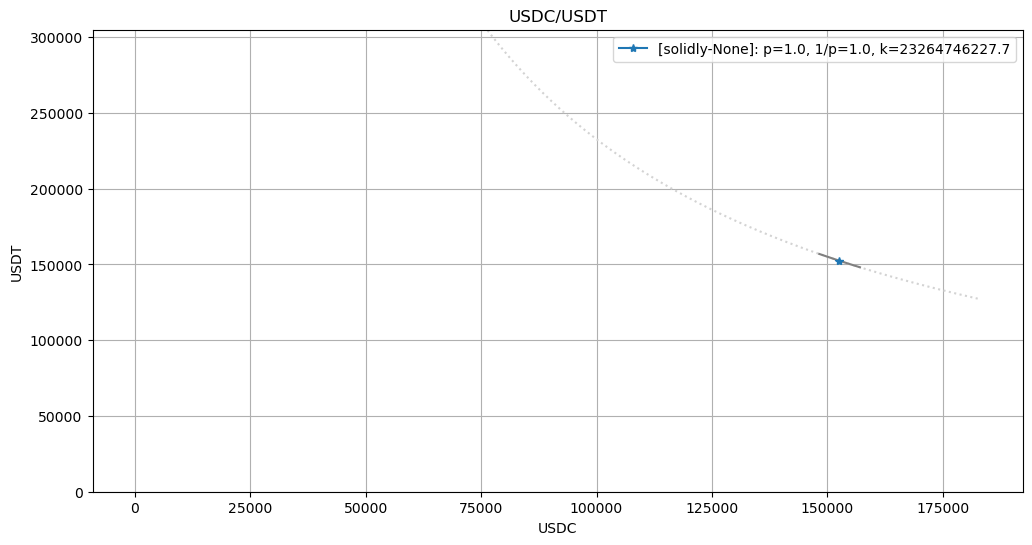

pair = WETH/USDC


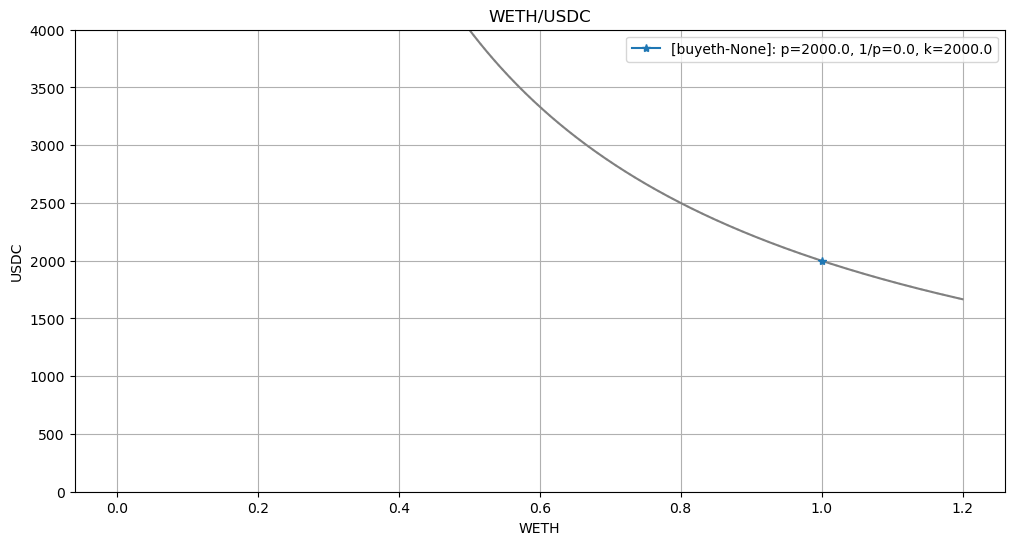

pair = WETH/USDT


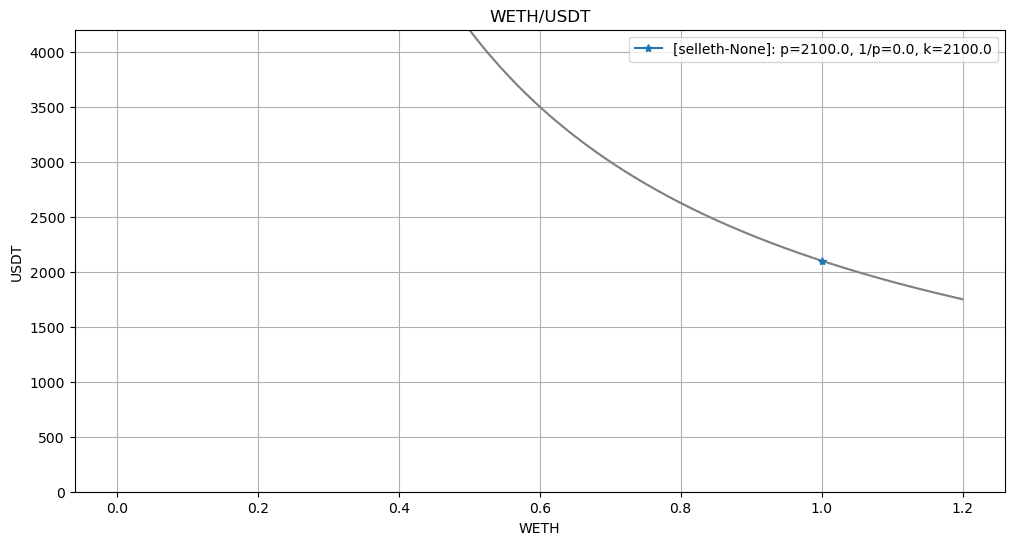

In [17]:
CC = CPCContainer()
CC += [CPC.from_pk(pair="WETH/USDC", cid="buyeth",  p=2000, k=2000)]
CC += [CPC.from_pk(pair="WETH/USDT", cid="selleth", p=2100, k=2100)]
CC += [CPC.from_solidly(pair="USDC/USDT", x=10000, y=10000, cid="solidly")]
O = MargPOptimizer(CC)
CC.plot()

We run the optimizer

In [18]:
r = O.optimize("USDC", params=dict(verbose=True))
rd = r.asdict
r

[margp_optimizer] targettkn = USDC
[margp_optimizer] crit=rel (eps=1e-06, unit=1, norm=L2)

[margp_optimizer] USDC <- WETH, USDT
[margp_optimizer] p    2,000.00, 1.00
[margp_optimizer] 1/p  0.00, 1.00

[margp_optimizer]
========== cycle 0 =======>>>
USDC <- WETH, USDT
dtkn   0.025, -51.479
log p0 [3.3010299956639813, 0.0003685841455740562]
d logp [ 0.01070394 -0.00014748]
log p  [3.31173393e+00 2.21108483e-04]
p_t      (2049.9059429866033, 1.000509250720048) USDC
p        2,049.91, 1.00
1/p      0.00, 1.00
crit     1.07e-02 [1; L2], eps=1e-06, c/e=1e+04]
<<<========== cycle 0 =======

[margp_optimizer]
========== cycle 1 =======>>>
USDC <- WETH, USDT
dtkn   0.000, 0.162
log p0 [3.311733934529401, 0.00022110848257232696]
d logp [6.81562959e-05 1.82648199e-06]
log p  [3.31180209e+00 2.22934965e-04]
p_t      (2050.2276715956777, 1.0005134585008217) USDC
p        2,050.23, 1.00
1/p      0.00, 1.00
crit     6.82e-05 [1; L2], eps=1e-06, c/e=7e+01]
<<<========== cycle 1 =======

[margp_optimi

CPCArbOptimizer.MargpOptimizerResult(result=-0.6271972654014917, time=0.0015058517456054688, method='margp', targettkn='USDC', p_optimal_t=(2050.22767783421, 1.0005134585841189), dtokens_t=(-5.861977570020827e-14, -6.184563972055912e-11), tokens_t=('WETH', 'USDT'), errormsg=None)

And we look at the curves again

pair = USDC/USDT


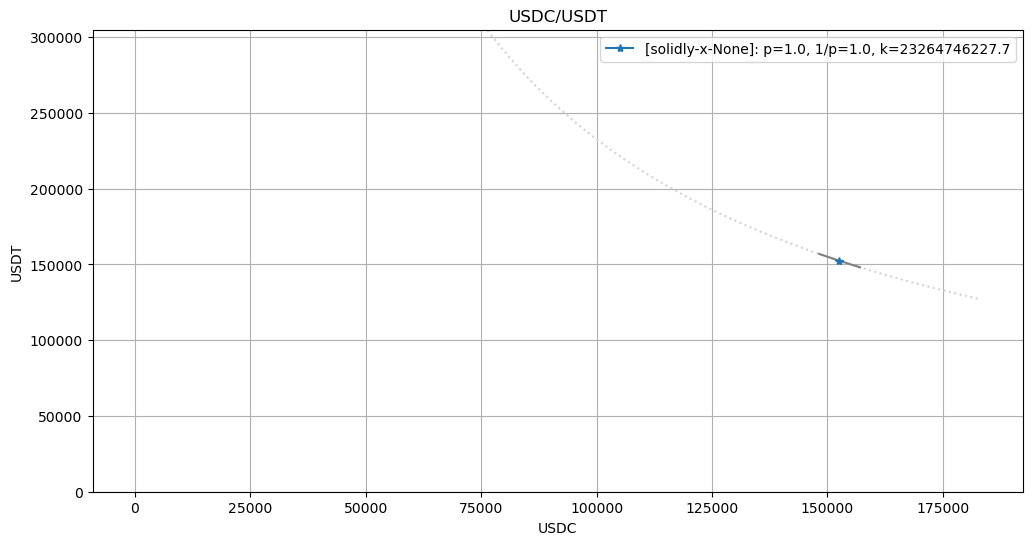

pair = WETH/USDC


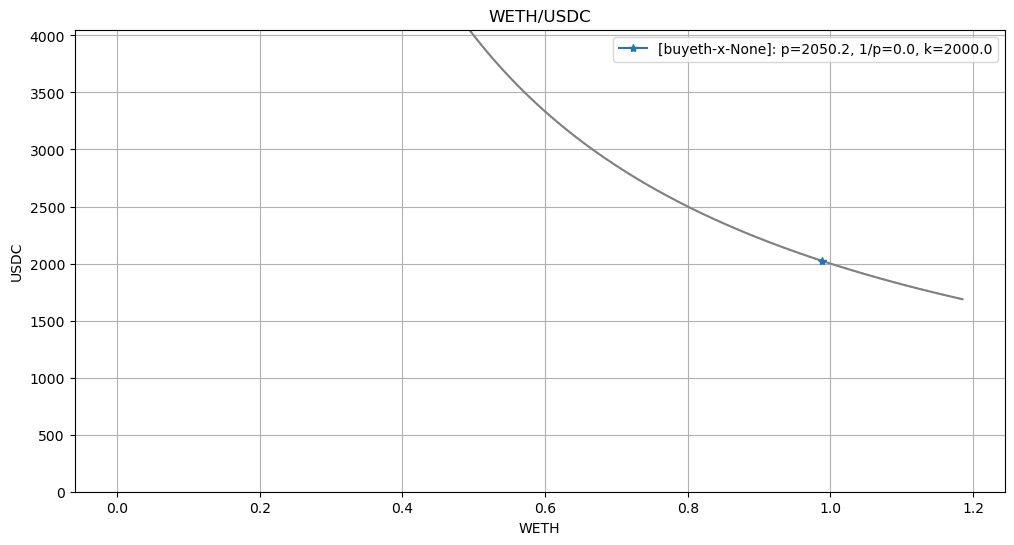

pair = WETH/USDT


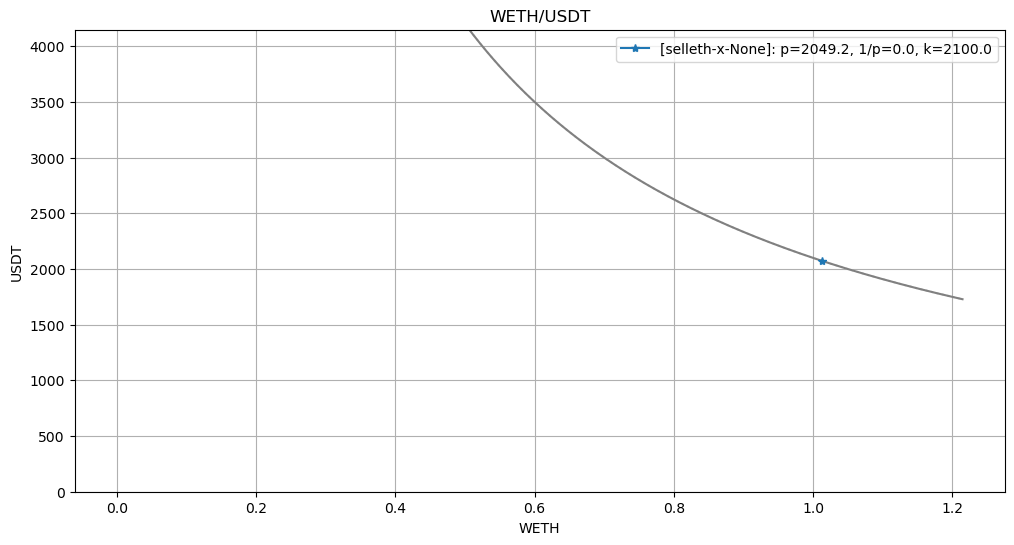

In [19]:
CC1 = r.curves_new
CC1.plot()

## Optimizer

In [20]:
CC = CPCContainer()
CC += [CPC.from_pk(pair="WETH/USDC", cid="buyeth",  p=2000, k=2000)]
CC += [CPC.from_pk(pair="WETH/USDT", cid="selleth", p=2100, k=2100)]
CC += [CPC.from_solidly(pair="USDC/USDT", x=10000, y=10000, cid="solidly")]
O = MargPOptimizer(CC)
#CC.plot()

In [21]:
r = O.optimize("USDC", params=dict(verbose=False))
rd = r.asdict()
r

CPCArbOptimizer.MargpOptimizerResult(result=-0.6271972654014917, time=0.0028679370880126953, method='margp', targettkn='USDC', p_optimal_t=(2050.22767783421, 1.0005134585841189), dtokens_t=(-5.861977570020827e-14, -6.184563972055912e-11), tokens_t=('WETH', 'USDT'), errormsg=None)

In [22]:
assert iseq(r.p_optimal["WETH"], 2050.22767783421, eps=1e-3)
assert iseq(r.p_optimal["USDT"], 1, eps=1e-3)
assert r.p_optimal["USDC"] == 1
r.p_optimal

{'WETH': 2050.22767783421, 'USDT': 1.0005134585841189, 'USDC': 1.0}

In [23]:
df = r.trade_instructions(ti_format=r.TIF_DF).fillna(0)
assert iseq(0, sum(df["USDT"]))
assert iseq(0, sum(df["WETH"]))
assert sum(df["USDC"]) < 0
assert sum(df["USDC"]) == r.result
assert iseq(r.result, -0.6271972654014917)
df

,pair,pairp,tknin,tknout,USDC,WETH,USDT
cid,,,,,,,
buyeth,WETH/USDC,WETH/USDC,USDC,WETH,24.958112,-0.012325,0.000000
selleth,WETH/USDT,WETH/USDT,WETH,USDT,0.000000,0.012325,-25.567891
solidly,USDC/USDT,USDC/USDT,USDT,USDC,-25.585309,0.000000,25.567891


In [24]:
CC1 = r.curves_new
c0,c1,c2 = [*CC1]
c0.cid, c0.pair, c0.p

('buyeth-x', 'WETH/USDC', 2050.22767783421)

In [25]:
c1.cid, c1.pair, c1.p

('selleth-x', 'WETH/USDT', 2049.175511077681)

In [26]:
c0.p/c1.p*c2.p

0.9999999999999997

In [27]:
1-c2.p

0.0005131950797002682

In [28]:
(c0.p/c1.p-1) / (1-c2.p)

1.0005134585833757

In [29]:
assert iseq(c0.p/c1.p-1, 1-c2.p, eps=1e-3)  # price ratio of ETH curves equals USDC/USDT price
assert iseq(c0.p/c1.p*c2.p, 1)              # circular exchange is unity